##         <pre>            Customer Review Sentiment Analysis System </pre>
###                   <pre>                              Garaje - San Francisco </pre>

In [1]:
# Click on "Voilà" to start 

In [2]:
# pip Install natural language processing tool and other required library

In [3]:
%%capture 
pip install nltk


In [4]:
%%capture 
pip install requests;

In [5]:
%%capture 
pip install ipywidgets;

In [6]:
%%capture 
pip install pandas

In [7]:
%%capture 
pip install matplotlib

In [8]:
import nltk
import ssl
import json
from nltk.corpus import stopwords
import requests
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets 
import matplotlib.dates as dates
from datetime import datetime

from IPython.display import display, clear_output
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from IPython.display import display, clear_output
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import pandas as pd
import matplotlib.pyplot as plt




try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [9]:
%%capture 
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/isaac/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# App specific required Yelp API parameters
Client_ID = "<ID>"
URL = "https://api.yelp.com/v3/businesses/tnhfDv5Il8EaGSXZGiuQGg/reviews"
URL2 =  "https://api.yelp.com/v3/businesses/search"
Header = { "Authorization": "Bearer <api key>" }
# Business name => business ID 
Garaje = 'tnhfDv5Il8EaGSXZGiuQGg'
Merkado = "tE3f3i7FnDUzpufeqBzsVA"
Kantana_YA = "F3bL-3Btko-JSupCC2pPAw"

## Please Select Business Name, Start Time, and End Time To Start Analysis 

In [11]:
# Makes a GET reqeuset to acquire data -> This will not be run in production since we have local cached value 
# r = requests.get(url = URL, headers = Header)
# r.json()['reviews']


In [12]:
start_time_selected = ''
end_time_selected = ''

Business_dropdown = widgets.Dropdown(
    options= ["Garaje", "Merkado"],
    value= None ,
    description='Business Name: ',
)
start_date = widgets.DatePicker(
    description='Start Date',
    disabled=False
)
end_date = widgets.DatePicker(
    description='End Date',
    disabled=False
)

def display_date(date, field):
    # check all fields 
    # run check
    print(Business_dropdown.value)
    
    if field == "start" and date:
        start_time_selected = date
        print("Selected start: " + str(start_time_selected))
        print("Now make sure End Date is also set")
    elif date:
        end_time_selected = date
        print("Selected end: " + str(end_time_selected))
        print("Now make sure Start Date is set and select Name to get report")
        
widgets.interact(display_date, date = start_date, field = "start")
widgets.interact(display_date, date = end_date, field = "end")

display(Business_dropdown)
output = widgets.Output()
display(output)




@output.capture()
def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
    
        if start_date.value and end_date.value:
            main_function(change['new'], start_date.value, end_date.value)
        else:
            print("Please select start and end time")
        
Business_dropdown.observe(on_change) 

interactive(children=(DatePicker(value=None, description='Start Date'), Text(value='start', description='field…

interactive(children=(DatePicker(value=None, description='End Date'), Text(value='end', description='field'), …

Dropdown(description='Business Name: ', options=('Garaje', 'Merkado'), value=None)

Output()

In [13]:
# sentiment_data = {'date':[],'compound':[]}
# sentiment_pecrentage = {'positive':0, 'negative':0, 'neutral':0}
sentiment_data= {}
sentiment_pecrentage= {}
date_format = '%Y-%m-%d'


In [14]:

def load_data(file_name):
    list_of_reviews = []
    with open(file_name, encoding='utf-8', errors = 'replace') as f:     
        for line in f:
            try:
                data = json.loads(line);
                list_of_reviews.append(data)
            except ValueError:
                pass
    return list_of_reviews

In [15]:
# Clean data - remove unimportant fields (keys)
keys_to_remove = ["user_id", "business_id", "useful", "funny", "cool", "id", "type", "useful"]

def clean_up_json(data_list):
    cleaned_up_data = []
    for data in data_list:
        for key in keys_to_remove:
            try:
                if key in data:
                    data.pop(key, None)
            except ValueError:
                pass   
        cleaned_up_data.append(data)
    return cleaned_up_data

In [16]:

# Takes a json data, star date, and end date to filter data to be in the given range 
# Add filtered data to date_filtered_data variable 

def filter_data_by_time(data_list, start_time, end_time): 
    date_filtered_data = []
    
    start_time = datetime.strptime(str(start_time), date_format)
    end_time = datetime.strptime(str(end_time), date_format)
    
    for data in data_list:
        time_created = datetime.strptime(data['time_created'].strip(), date_format)
        if start_time < time_created < end_time:
            date_filtered_data.append(data)
    return date_filtered_data

In [17]:

# Takes a list of review data 
# Tokenize the text
# Calculate word repetition 
# Then plot bargraph 

def bag_of_words_graph(data_list):
    word_tokens = []
    for data in data_list:
        lower_full_text = data['text'].lower()
        word_tokens.append(word_tokenize(lower_full_text))
    tokens = list()
    for token in word_tokens:
        for word in token:
            if word.isalpha() and word not in stop_words:
                tokens.append(word)
    token_dist = FreqDist(tokens)
    dist = pd.DataFrame(token_dist.most_common(20), columns=['Word', 'Frequency'])
    fig, ax = plt.subplots(figsize=(12, 8))
    # plot horizontal bar plot
    dist.sort_values(by='Frequency').plot.barh(x="Word", y="Frequency", ax=ax)
    # set the title
    plt.title("Most mentioned words")
    plt.show()

In [18]:

# Takes a list of review data 
# Initalize sentiment analyser to calculate sentiment 
# Count every sentiment class for percentage calcualtion

def analyze_review_sentiment(data_list):
    # reset variables
    sentiment_data['date'] = []
    sentiment_data['compound'] = []
    sentiment_pecrentage["positive"] = 0
    sentiment_pecrentage["negative"] = 0
    sentiment_pecrentage["neutral"] = 0
    
   
    sid = SentimentIntensityAnalyzer()
    for data in data_list:
        lower_full_text = data['text'].lower()
        ss = sid.polarity_scores(lower_full_text)
        sentiment_data["date"].append(data['time_created'])
        sentiment_data["compound"].append(ss['compound'])
            
            
        
        if (ss['pos'] > 0.5):
            sentiment_pecrentage['positive'] = sentiment_pecrentage['positive'] + 1
        elif (ss['neg'] > 0.5):
            sentiment_pecrentage['negative'] = sentiment_pecrentage['negative'] + 1
        else:
            sentiment_pecrentage['neutral'] = sentiment_pecrentage['neutral'] + 1
            

In [32]:

Garaje_file = 'ReviewFile.json';
Merkado_file = 'second_review.json';
stop_words = set(stopwords.words('english'));


def main_function(bussiness_name, start_time, end_time):
    data_set = []
    if (bussiness_name == "Merkado"):
        data_set = load_data(Merkado_file)
    else:
        data_set = load_data(Garaje_file)
        
        
    cleaned_data = clean_up_json(data_set)
    
    date_filtered_data = filter_data_by_time(cleaned_data, start_time, end_time)
    if len(date_filtered_data) > 0:
        bag_of_words_graph(date_filtered_data)
        analyze_review_sentiment(date_filtered_data)
        error2 = widgets.HTML(value="<h1>Below Pie Chart to visualize each sentiment class percentage (Positive, neutral, and negative)</h1>")
        display(error2)
        plt.pie(sentiment_pecrentage.values(), labels=sentiment_pecrentage.keys(), radius = 4,autopct='%1.1f%%')
        plt.rcParams['interactive']
        plt.axis('equal')
        plt.show()
        error3 = widgets.HTML(value="<h1></h1>")
        display(error3)
        error2 = widgets.HTML(value="<h2>Below time-series report for reviews in the selected time range is dispalyed </h2>")
        display(error2)
        
    else:
        error = widgets.HTML(value="<h2>No review was found for this time range. Please update the time and reselect business name</h2>")
        display(error)
    
    
    
    
    

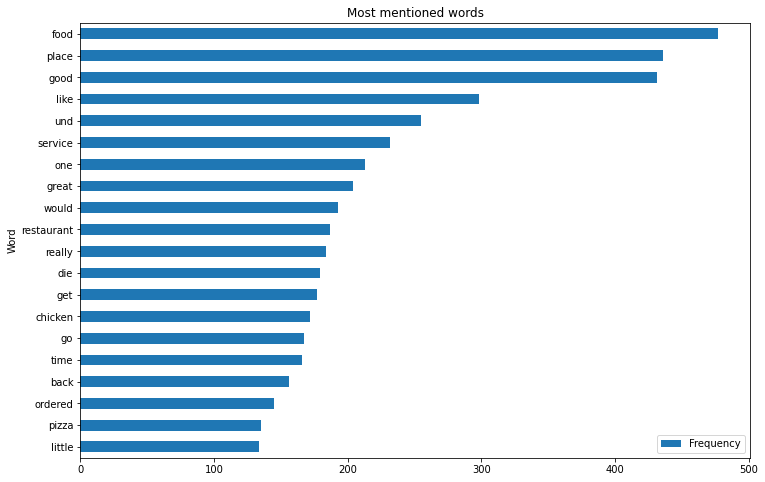

HTML(value='<h1>Below Pie Chart to visualize each sentiment class percentage (Positive, neutral, and negative)…

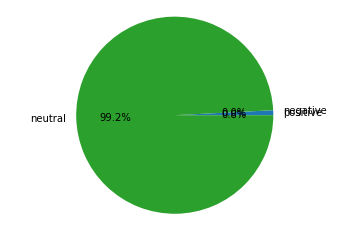

HTML(value='<h1></h1>')

HTML(value='<h2>Below time-series report for reviews in the selected time range is dispalyed </h2>')

<AxesSubplot:xlabel='date', ylabel='Compound Sentiment'>

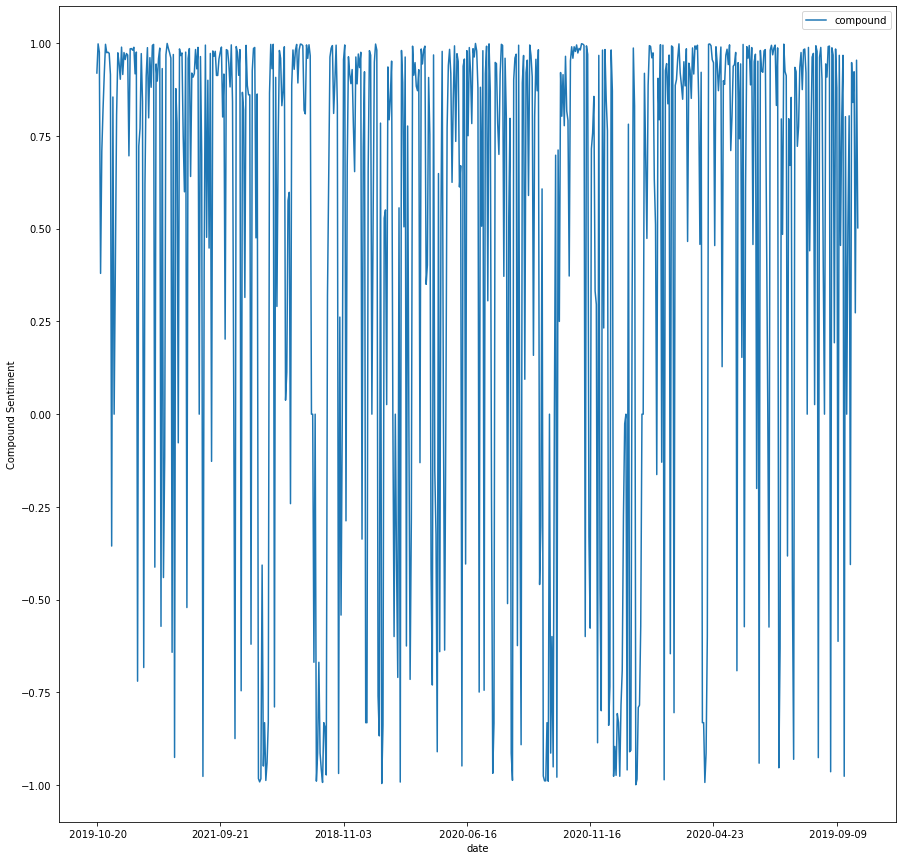

In [33]:
note = widgets.HTML(value="<h1>THESE GRAPHS BELOW ARE INITIAL GRAPHS! THE BAR GRAPH AND PIE CHART WILL UPDATE AS TIME AND NAME CHANGES</h1>")
display(note)
main_function('Merkdo', '2017-02-02', '2022-07-02', initial = True)
fig, ax = plt.subplots(1)
df = pd.DataFrame(sentiment_data)
ax.legend(["date", "compound"])
ax.set_xlabel('Date')
ax.set_ylabel('Compound Sentiment')
df.plot("date", "compound",figsize=(15,15), ax=ax)


In [21]:
        # Takes sentiment_pecrentage above to generate pie chart to show every class percentage
